### Loading Libraries and Dataset

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
import random
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#pd.set_option("display.max_column", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\hp\Downloads\WEEK 174 STATE LINELIST.csv")

In [3]:
df['CurrentARTStatus'].value_counts()

CurrentARTStatus
Active               73488
LTFU                 24183
Discontinued Care     7116
Transferred out       3168
Death                 2530
Name: count, dtype: int64

#### Data Anonymization and Removing Irrelevant Columns

In [4]:
fake = Faker()

In [5]:
def anonymize_data(df):
    df['Patient_Name'] = df['Patient_Name'].apply(lambda x: fake.name())
    df['ART_ID'] = df['ART_ID'].apply(lambda x: fake.phone_number())
    df['Patient_Address'] = df['Patient_Address'].apply(lambda x: fake.address().replace('\n', ' '))
    df['Patient_LGA'] = df['Patient_LGA'].apply(lambda x: fake.address().replace('\n', ' '))
    return df

anonymized_df = anonymize_data(df)

In [6]:
anonymized_df = anonymized_df.drop(['Facility_Name', 'IP', 'Datim_Code', 'HospitalNo','Patient_LGA',
                                   'Patient_State', 'State', 'Phone_No'], axis = 1)

In [7]:
data = anonymized_df

### EDA and Data Cleaning

In [8]:
def clean_data(data):
    ''' This function cleans some of the basic irregularities in the dataset such as datatype structuring, filling null values'''
    data.drop(['Age_in_months', 'setting', 'DOB'], axis = 1, inplace = True) # drop irrelevant columns 
    # convert selected columns to datetime datatype
    conv_to_datetime = ['EnrollmentDate', 'ART_Start_Date', 'ViralLoadReportedDate', 'Clinic_Visit_Lastdate', 'Pharmacy_LastPickupdate',
                    'stamp_date', 'DateofCurrentViralLoad', 'ViralLoadReportedDate', 'LastDateOfSampleCollection', 'TBStatusDate',
                    'INHStartDate',	'INHStopDate',	'LastINHDispensedDate',	'TBTreatmentStartDate',	'TBTreatmentStopDate',	
                    'OTZStartDate',	'OTZStopDate', 'DateofFirstDTGPickup', 'Termination_Date', 'Next_Visit_Date',	
                    'Next_Ap_by_pharmPill',	'Next_Ap_by_careCard', 'Biometric_date', 'Date_Generated']
    for col in conv_to_datetime:
        data[col] = pd.to_datetime(data[col], errors = 'coerce') 
    # Convert to integer
    conv_to_int = ['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'CurrentViralLoad', 'CurrentWeight_Kg', 'CurrentHeight_Kg', 'Days_To_Schedule']
    for cols in conv_to_int:
        data[cols] = pd.to_numeric(data[cols], errors = 'coerce')   
    data.rename(columns={'CurrentHeight_Kg': 'CurrentHeight_cm'}, inplace=True)
    # fill null values for age data.
    average_female_age = data[data['Sex'] == 'Female']['Age_At_Start'].mean().round(0)
    average_male_age = data[data['Sex'] == 'Male']['Age_At_Start'].mean().round(0)
    data.loc[data['Sex'] == 'Female', 'Age_At_Start'] = data[data['Sex'] == 'Female']['Age_At_Start'].fillna(average_female_age)
    data.loc[data['Sex'] == 'Male', 'Age_At_Start'] = data[data['Sex'] == 'Male']['Age_At_Start'].fillna(average_male_age)
    
    return data

In [9]:
clean_data(data)

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,...,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,TransferInStatus,TransferInDate,Biometric_Status,Biometric_date,Date_Generated
0,001-635-259-7047x4029,M,47.0,Michele Watson,"9066 Shaun Groves Apt. 401 Port Bridgetmouth, ...",42.0,2017-08-03,2017-08-03,2022-03-10,2022-03-10,...,Active With Drugs,2022-09-06,2022-09-06,2022-09-06,12.0,NaN,NaN,Yes,2021-01-07,2022-08-25 19:25:00
1,(371)739-3213x677,F,33.0,Maria Morales,42105 Michael Corner Suite 597 East Robertvill...,27.0,2016-06-13,2016-06-13,2016-06-13,2016-06-13,...,LTFU,2016-07-13,NaT,NaT,-2234.0,NaN,NaN,No,NaT,2022-08-25 19:25:00
2,689.674.4485,M,54.0,William Rosales,"8202 Smith Branch Baileytown, CT 92800",49.0,2017-06-29,2017-06-29,2022-04-14,2022-04-14,...,Active With Drugs,2022-10-11,2022-10-11,2022-10-11,47.0,NaN,NaN,Yes,2021-02-04,2022-08-25 19:25:00
3,5334304742,F,35.0,Jeffrey Saunders,"81497 White Burgs New Kimton, LA 23954",30.0,2017-03-16,2017-03-17,2020-04-28,2020-04-28,...,LTFU,2020-07-27,NaT,2020-07-23,-759.0,NaN,NaN,No,NaT,2022-08-25 19:25:00
4,747-948-3693,F,67.0,Lisa Aguilar,"51080 Timothy Locks Davidsonshire, FM 83084",62.0,2017-05-25,2017-05-25,2022-04-28,2022-04-28,...,Active With Drugs,2022-10-25,2022-10-25,2022-10-25,61.0,NaN,NaN,Yes,2021-05-05,2022-08-25 19:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,+1-322-562-1714x077,M,39.0,William Whitaker,"67003 Barry Isle South Johnberg, WV 56989",30.0,2013-10-02,2013-10-02,2022-08-24,2022-08-24,...,Active With Drugs,2022-11-22,2022-11-22,2022-11-25,85.0,NaN,NaN,Yes,2022-08-24,2022-08-29 09:58:00
110481,+1-819-660-3521x24615,M,52.0,John Johnson,Unit 3566 Box 2904 DPO AA 10493,NaN,2022-05-11,NaT,NaT,NaT,...,LTFU,NaT,NaT,NaT,NaN,NaN,NaN,No,NaT,2022-08-29 09:58:00
110482,823-575-4592,M,37.0,Christine Romero,"348 Jason Lights Kristinabury, KS 45704",NaN,2022-08-24,NaT,NaT,NaT,...,LTFU,NaT,NaT,NaT,NaN,NaN,NaN,Yes,2022-08-25,2022-08-29 09:58:00
110483,(682)354-1572,F,32.0,Michelle Rodriguez,"639 Natasha Falls Apt. 398 Port Peter, WI 68651",32.0,2022-08-24,2022-08-24,2022-08-24,2022-08-24,...,Active With Drugs,2022-11-22,2022-11-22,2022-11-23,85.0,NaN,NaN,Yes,2022-08-25,2022-08-29 09:58:00


In [10]:
# performing a descriptive statistics
data.select_dtypes(['float', 'int']).describe()

,current_Age,Age_At_Start,DaysOfARVRefill,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,Days_To_Schedule
count,110483.000000,101373.000000,98620.000000,7.215100e+04,96096.000000,79141.000000,99003.000000
mean,37.398405,32.611070,138.558315,1.000956e+04,63.126291,163.274457,-363.611709
std,13.029286,12.066687,57.714790,4.011296e+05,15.769130,17.953361,1006.875580
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000,5.000000,-7301.000000
25%,28.000000,25.000000,90.000000,5.000000e+00,55.000000,158.000000,-37.000000
50%,36.000000,31.000000,180.000000,1.000000e+01,64.000000,165.000000,53.000000
75%,45.000000,40.000000,180.000000,1.900000e+01,72.000000,172.000000,100.000000
max,119.000000,113.000000,180.000000,1.000000e+08,250.000000,270.000000,180.000000


In [11]:
# calculate null percentage and drop columns above 50% null percentage
cols_above_50 = []
for cols in data.columns:
    null_percentage = data[cols].isnull().mean()*100
    if null_percentage > 50:
        cols_above_50.append(cols)

# drop these columns
data.drop(cols_above_50, axis = 1, inplace = True)

In [12]:
# Show unique values in categorical features
categorical_features = ['Sex', 'CurrentRegimenLine', 'TBStatus', 'Appointment_Status',
                       'RegimenLineAtARTStart',	'RegimenAtARTStart', 'CurrentARTRegimen', 'ViralLoadIndication', 'DTGFirstPickUp',	
                       'CurrentARTStatus',	'Biometric_Status']
for feature in categorical_features:
    print(f"{data[feature].value_counts()}\n")

Sex
F         63407
M         46355
Female      524
Male        197
Name: count, dtype: int64

CurrentRegimenLine
Adult 1st line ARV regimen     98205
Child 1st line ARV regimen      1933
Adult 2nd line ARV regimen      1208
Child 2nd line ARV regimen       100
Adult 3rd Line ARV Regimens       27
One                               24
Two                                1
Child 3rd Line ARV Regimens        1
AZT-3TC-DTG                        1
Name: count, dtype: int64

TBStatus
No signs or symptoms of disease    97519
Currently on INH prophylaxis        1460
Disease suspected                   1129
On treatment for disease             269
Completed treatment for disease      251
Disease diagnosed                    105
27-Jul-22                              1
Name: count, dtype: int64

Appointment_Status
Active With Drugs     71483
LTFU                  36481
Missed Appointment     2502
Today Visit              19
Name: count, dtype: int64

RegimenLineAtARTStart
Adult 1st line ARV regi

In [14]:
# convert categorical features to category
data[categorical_features] = data[categorical_features].astype('category')

In [37]:
# inconsistency in SEX, replace F with Female and M with Male
data['Sex'].replace({"F":'Female', 'M':'Male'}, inplace = True)

In [33]:
data.isnull().sum()

ART_ID                            0
Sex                               0
current_Age                       2
Patient_Name                      0
Patient_Address                   0
Age_At_Start                   9111
EnrollmentDate                  506
ART_Start_Date                 9111
Clinic_Visit_Lastdate          8986
Pharmacy_LastPickupdate       13083
stamp_date                    10949
DaysOfARVRefill               11864
RegimenLineAtARTStart             0
RegimenAtARTStart                 0
CurrentRegimenLine                0
CurrentARTRegimen                 0
CurrentViralLoad              38333
DateofCurrentViralLoad        38329
LastDateOfSampleCollection    36505
ViralLoadReportedDate         47428
ViralLoadIndication               0
CurrentWeight_Kg              14388
CurrentWeightDate             14388
CurrentHeight_cm              31343
CurrentHeightDate             31343
TBStatus                          0
TBStatusDate                   8971
INHStartDate                

<Axes: >

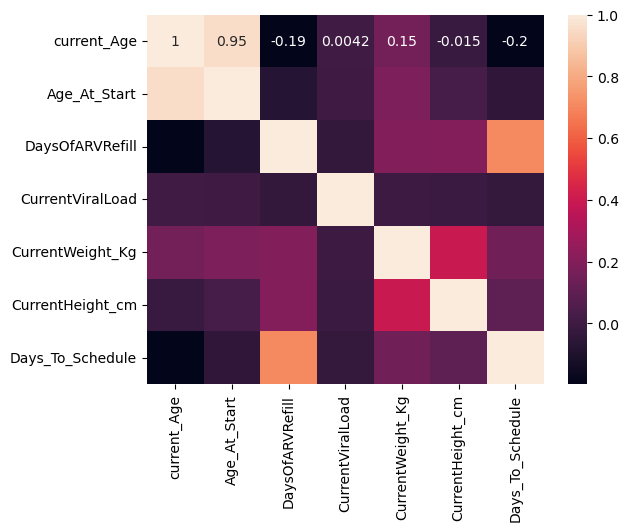

In [15]:
# Check correlation between variables
corr_matrix = data.select_dtypes(['int', 'float']).corr()
sns.heatmap(corr_matrix, annot = True)

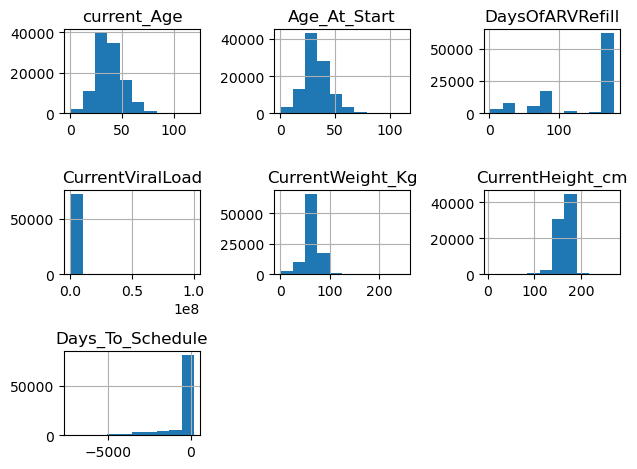

In [16]:
# check distribution for categorical variable
data.select_dtypes(['int', 'float']).hist()
plt.tight_layout()
plt.show()

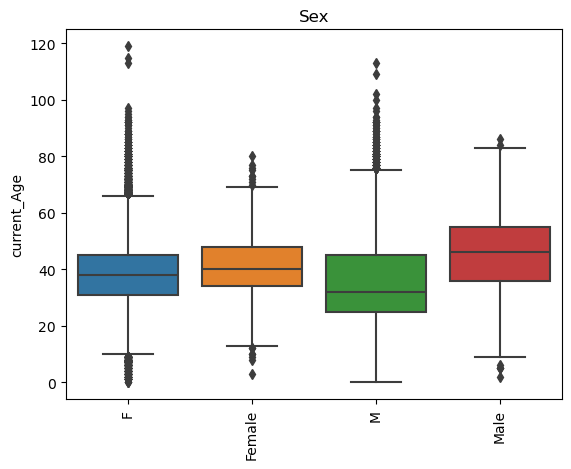

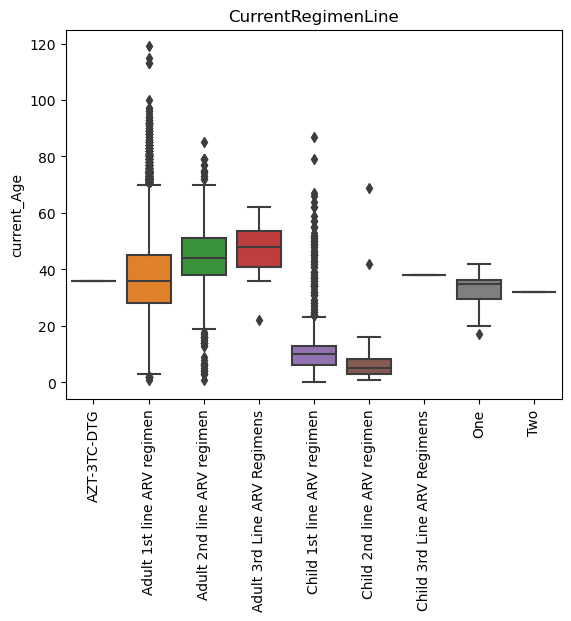

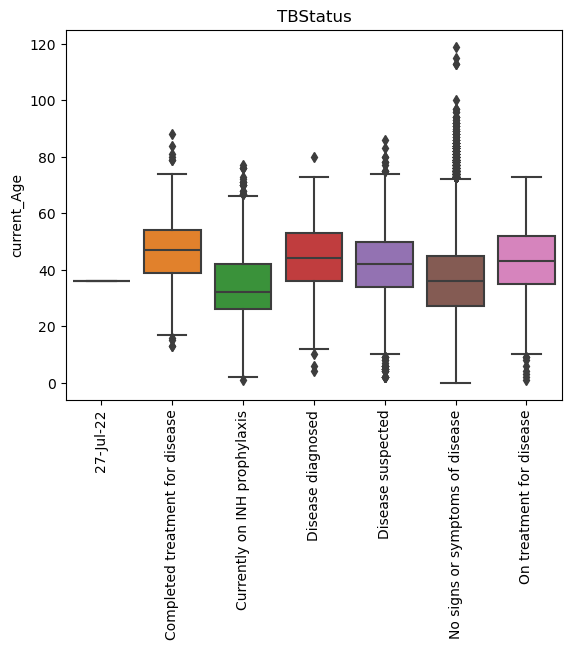

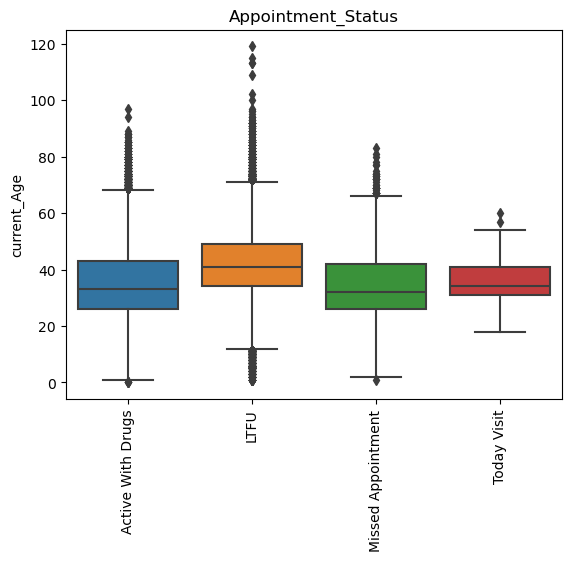

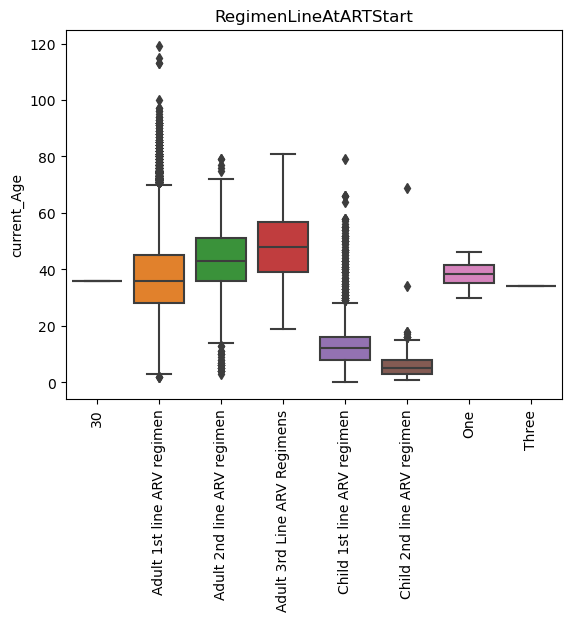

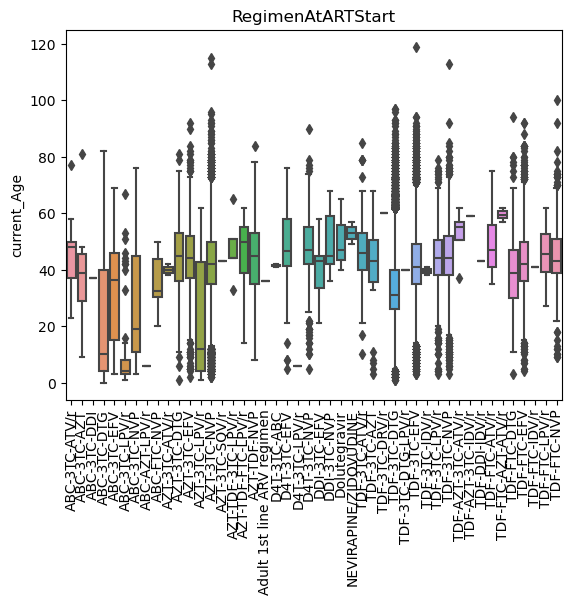

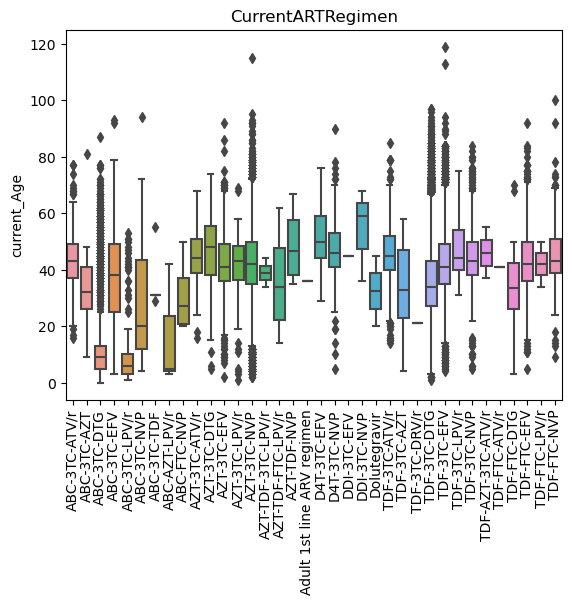

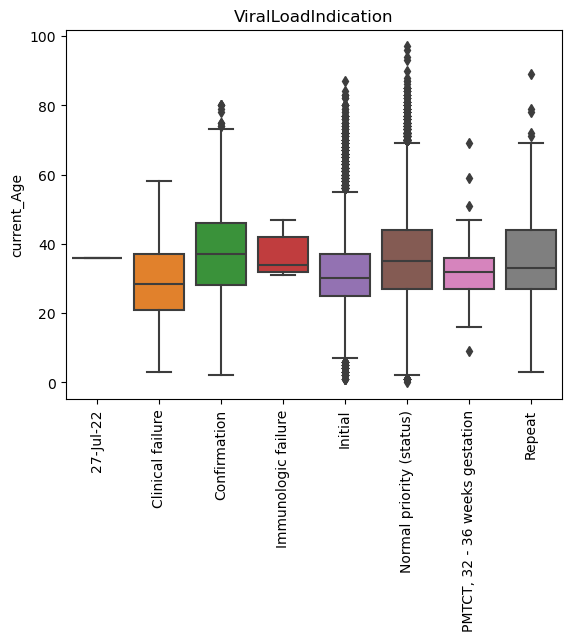

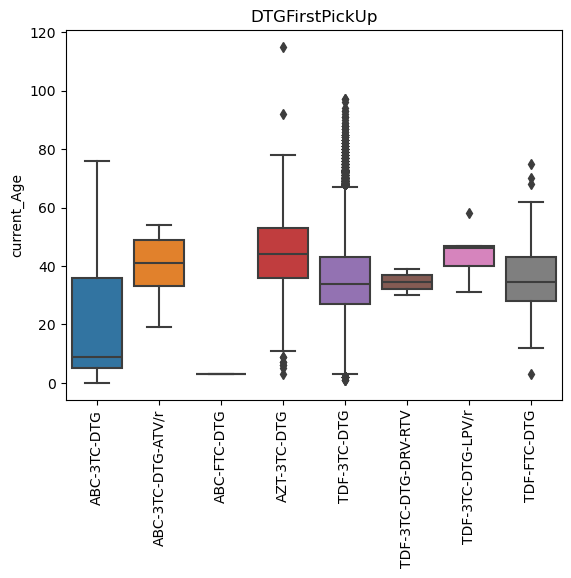

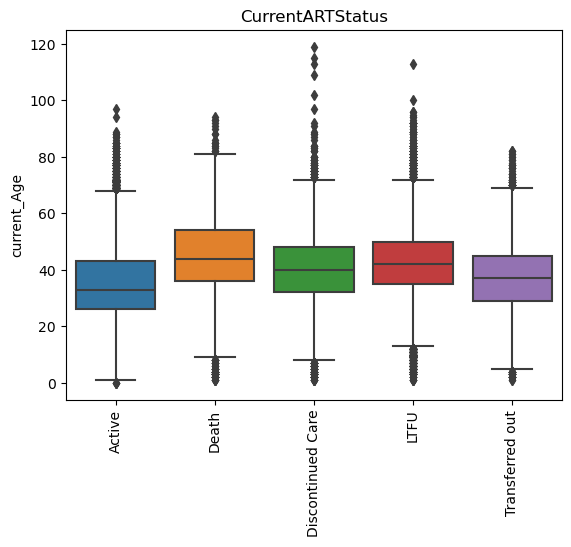

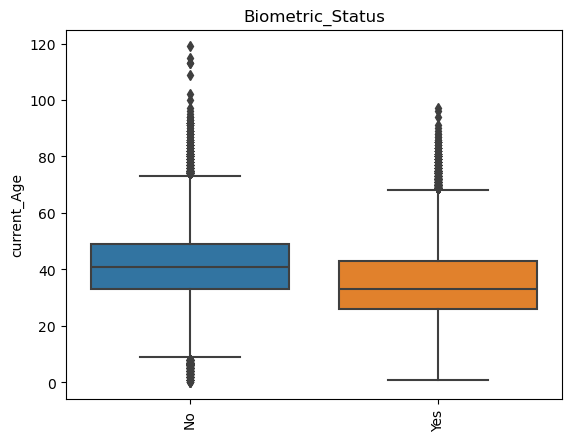

In [17]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()

In [18]:
# discovered an inconsistency and clean "27-Jul-22"
data[data['TBStatus'] == '27-Jul-22']

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,...,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated
96353,(291)630-5777x0408,M,36.0,Amy Mueller,"924 Foster Highway Apt. 761 Veronicafort, KY 7...",NaN,NaT,2018-11-12,NaT,2022-07-27,...,2018-12-03,Active,Today Visit,2022-08-26,2022-08-26,2022-08-26,0.0,Yes,2021-01-20,NaT


In [19]:
# drop the row
data = data[data['TBStatus'] != '27-Jul-22']

In [20]:
data[data['RegimenLineAtARTStart'] == '30'] # The above code has taken care of the 30 outlier in RegimenLineAtARTStart column

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,...,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated


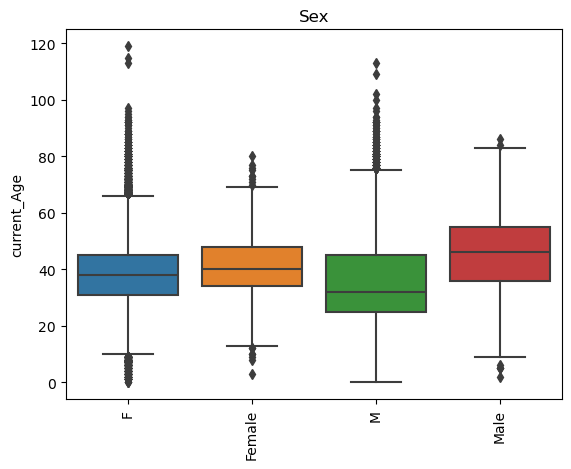

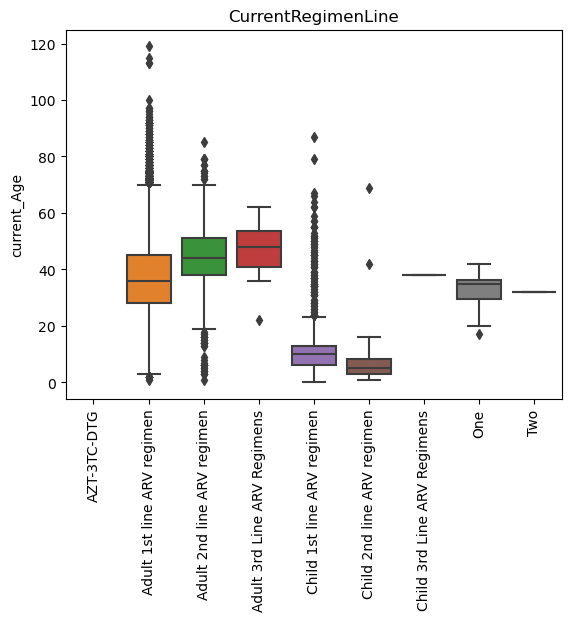

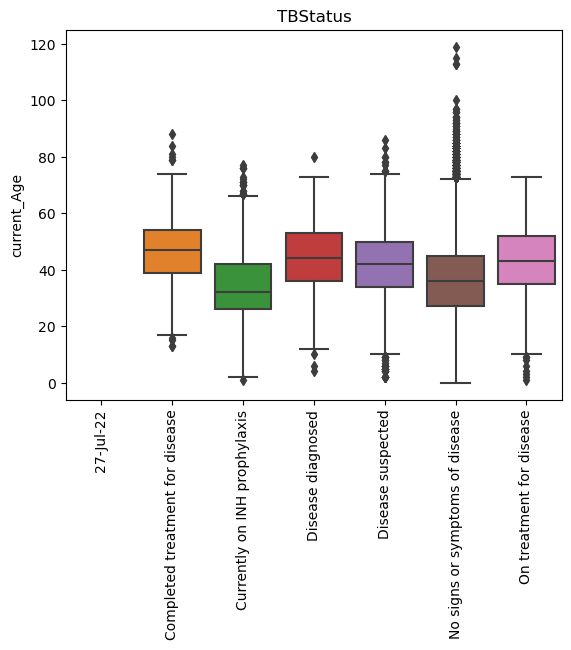

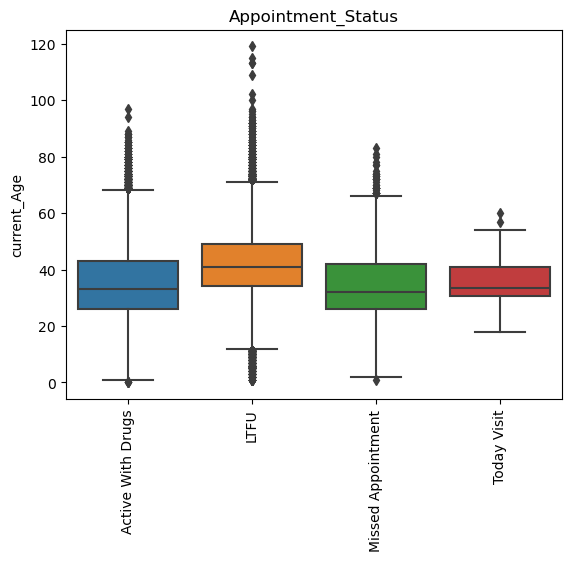

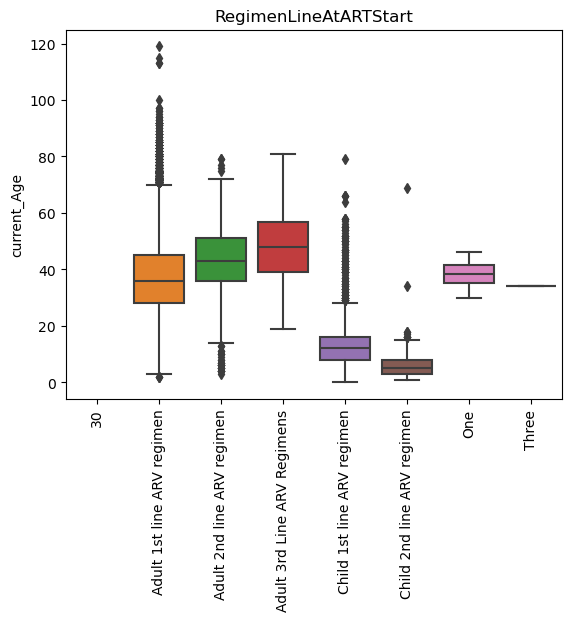

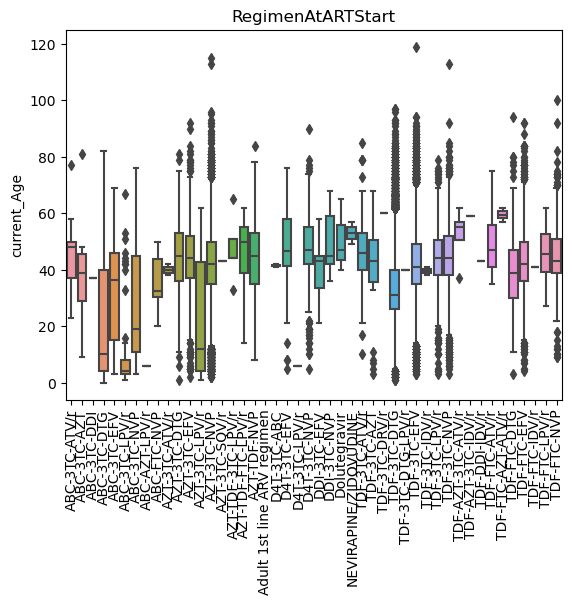

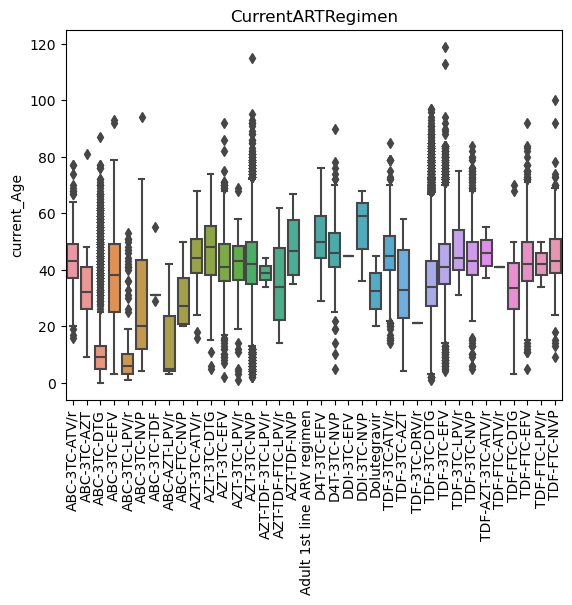

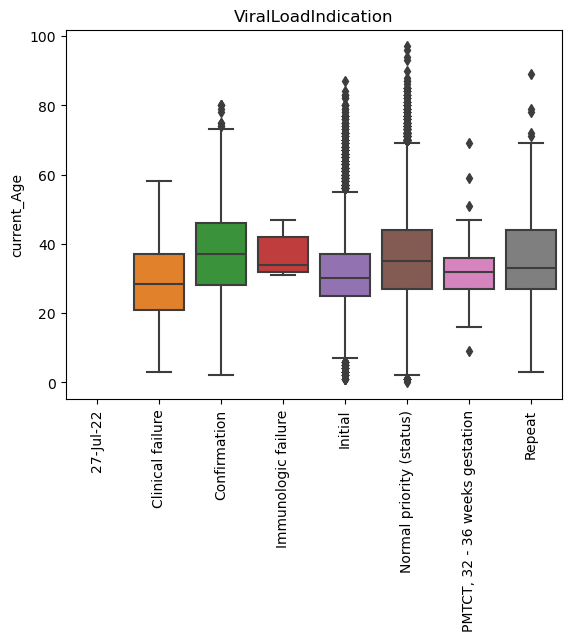

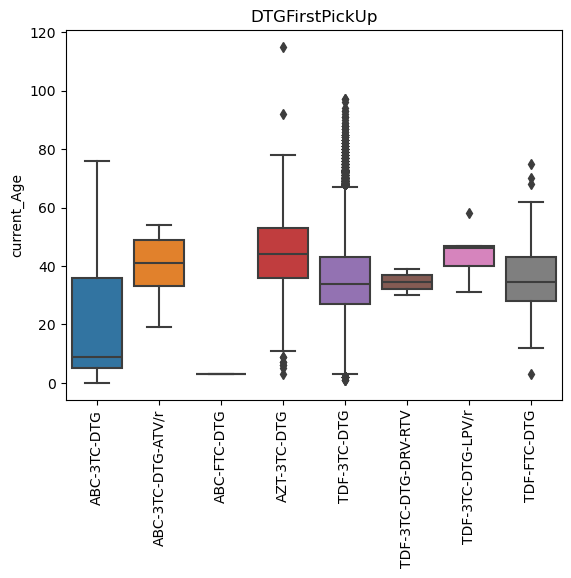

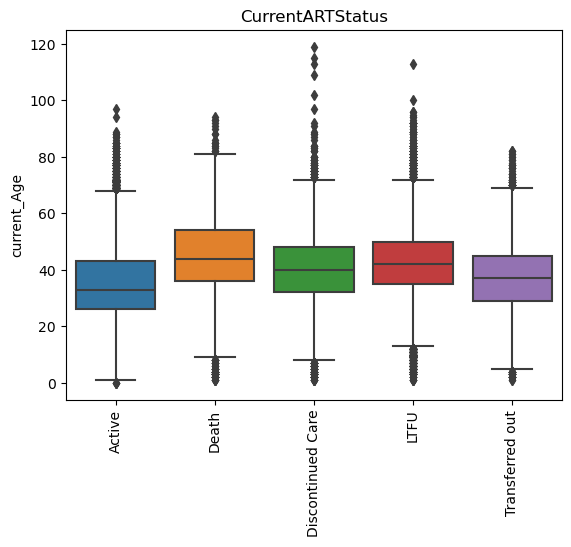

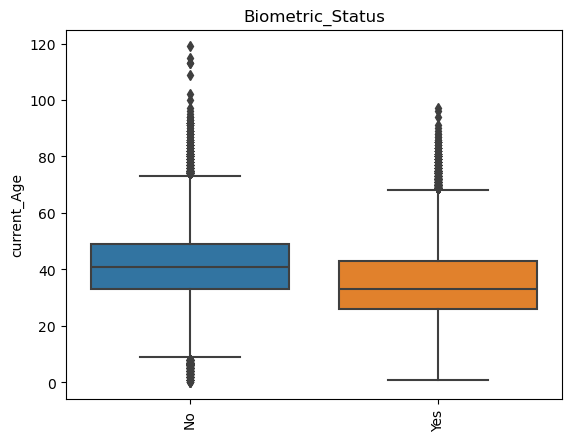

In [21]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()

### Predictive Analysis

Build a predictive model to understand and predict patients adherance to treatment.This can help healthcare industries understand patients reactions to Anti-retro viral therapy (ART), and also to understand factors that will probably affect patient response to ART treatment.

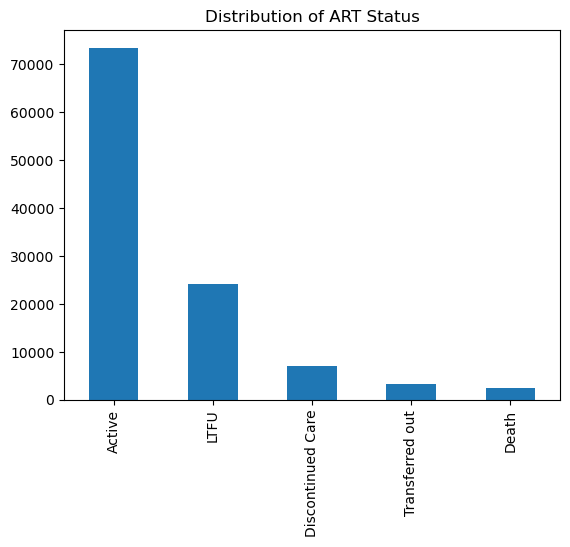

In [22]:
data['CurrentARTStatus'].value_counts().plot.bar()
plt.title('Distribution of ART Status')
plt.xlabel('')
plt.show()

### Feature Selection

In [23]:
from sklearn.feature_selection import mutual_info_regression

feature_data = data.copy()
x = feature_data
y = feature_data.pop('CurrentARTStatus')

# Encoding Categorical variables
for col in feature_data.select_dtypes(['object', 'category']):
    x[col],_ = x[col].factorize()

# Encoding y variable
y,_ = y.factorize()

<Axes: >

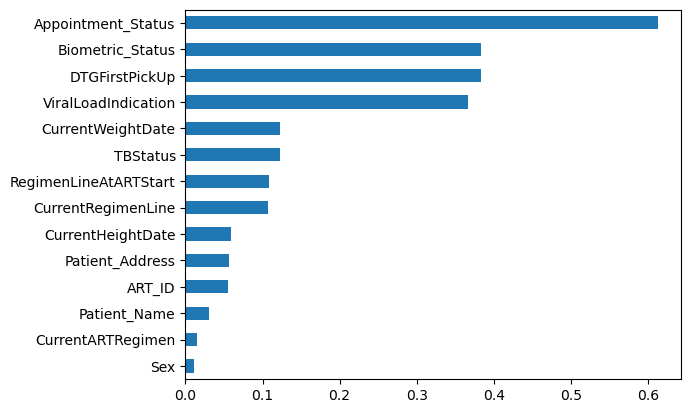

In [24]:
# Building Mutual Regression Model
x = x.select_dtypes('int64')
mi_scores = mutual_info_regression(x,y, random_state = 0)
mi_scores = pd.Series(mi_scores, index = x.columns)
best_features = mi_scores.sort_values(ascending = False).head(14)

# Show features relationship to target variable
best_features.sort_values(ascending = True).plot(kind = 'barh')

### Feature Encoding

In [25]:
# Fill null values in categorical columns with mode
for col in data.select_dtypes('category'):
    data[col] = data[col].fillna(data[col].mode().iloc[0])

In [26]:
# show cardinality count
print('This counts number of unique value in the categorical variable\n')
for col in data.select_dtypes('category'):
    print(f"{col} : {data[col].value_counts().nunique()}\n")

This counts number of unique value in the categorical variable

Sex : 4

RegimenLineAtARTStart : 8

RegimenAtARTStart : 30

CurrentRegimenLine : 8

CurrentARTRegimen : 29

ViralLoadIndication : 8

TBStatus : 7

DTGFirstPickUp : 8

CurrentARTStatus : 5

Appointment_Status : 4

Biometric_Status : 2



In [27]:
# import Binary Encoding for encoding categorical variable
from category_encoders import BinaryEncoder

In [38]:
# Encode Sex and Biometric_Status
pred_data = data.copy()
encoder = BinaryEncoder()
pred_data[['Sex_Female','Sex_Male',	'Biometric_Status_No','Biometric_Status_Yes']] = encoder.fit_transform(pred_data[['Sex', 'Biometric_Status']])

In [40]:
# Encode selected columns using get_dummies - one hot encoding technique
pred_data_encoded= pd.get_dummies(pred_data, columns=['RegimenLineAtARTStart', 'TBStatus', 'ViralLoadIndication', 'DTGFirstPickUp',
                                           'CurrentRegimenLine', 
                                           'Appointment_Status'])

In [42]:
# calculate frequency of each category and encode using those frequencies - Frequency Encoding 
regimen_at_start_freq = pred_data_encoded['RegimenAtARTStart'].value_counts(normalize=True)
current_art_regimen_freq = pred_data_encoded['CurrentARTRegimen'].value_counts(normalize=True)
print(regimen_at_start_freq)
print(current_art_regimen_freq)

# Replace categories with frequencies
pred_data_encoded['RegimenAtARTStart'] = pred_data_encoded['RegimenAtARTStart'].map(regimen_at_start_freq)
pred_data_encoded['CurrentARTRegimen'] = pred_data_encoded['CurrentARTRegimen'].map(current_art_regimen_freq)

RegimenAtARTStart
TDF-3TC-DTG                   0.639667
TDF-3TC-EFV                   0.201414
AZT-3TC-NVP                   0.089968
TDF-FTC-EFV                   0.020935
TDF-3TC-NVP                   0.011613
AZT-3TC-EFV                   0.007739
D4T-3TC-NVP                   0.004779
TDF-FTC-NVP                   0.003666
TDF-3TC-LPV/r                 0.003467
TDF-FTC-DTG                   0.002960
ABC-3TC-DTG                   0.002471
ABC-3TC-LPV/r                 0.002218
TDF-3TC-ATV/r                 0.002181
AZT-3TC-DTG                   0.001964
ABC-3TC-NVP                   0.001095
ABC-3TC-EFV                   0.001014
D4T-3TC-EFV                   0.000634
AZT-TDF-NVP                   0.000534
AZT-3TC-LPV/r                 0.000380
TDF-3TC-AZT                   0.000281
TDF-FTC-LPV/r                 0.000163
ABC-FTC-NVP                   0.000127
TDF-FTC-ATV/r                 0.000118
ABC-3TC-ATV/r                 0.000118
DDI-3TC-EFV                   0.000063
ABC-3TC

In [43]:
# drop irrelevant columns
pred_data_encoded = pred_data_encoded.drop(['ART_ID', 'Sex', 'Patient_Name', 'Patient_Address'], axis = 1)

In [44]:
# final view of dataset and the columns
pred_data_encoded.head(1)

,current_Age,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,RegimenAtARTStart,CurrentARTRegimen,...,CurrentRegimenLine_Adult 3rd Line ARV Regimens,CurrentRegimenLine_Child 1st line ARV regimen,CurrentRegimenLine_Child 2nd line ARV regimen,CurrentRegimenLine_Child 3rd Line ARV Regimens,CurrentRegimenLine_One,CurrentRegimenLine_Two,Appointment_Status_Active With Drugs,Appointment_Status_LTFU,Appointment_Status_Missed Appointment,Appointment_Status_Today Visit
0,47.0,42.0,2017-08-03,2017-08-03,2022-03-10,2022-03-10,2022-03-11 12:57:00,180.0,0.089968,0.836393,...,False,False,False,False,False,False,True,False,False,False


In [146]:
# Copy to ART_data
ART_data = pred_data_encoded.copy()

In [147]:
# replace True and False values with 1 and 0
ART_data.replace({True: 1, False: 0}, inplace=True)

In [148]:
label_encoder = LabelEncoder()

# Fit and transform the data
ART_data['CurrentARTStatus'] = label_encoder.fit_transform(ART_data['CurrentARTStatus'])

In [149]:
ART_data['CurrentARTStatus'].value_counts()

CurrentARTStatus
0    73487
3    24183
2     7116
4     3168
1     2530
Name: count, dtype: int64

In [150]:
ART_data.drop(columns = ART_data.select_dtypes('datetime64'), axis = 1, inplace = True)

In [151]:
ART_data.drop(columns = ['CurrentWeightDate', 'CurrentHeightDate', 'Biometric_Status',
                        'CurrentViralLoad', 'RegimenLineAtARTStart_30', 'RegimenLineAtARTStart_30',
       'RegimenLineAtARTStart_Adult 1st line ARV regimen',
       'RegimenLineAtARTStart_Adult 2nd line ARV regimen',
       'RegimenLineAtARTStart_Adult 3rd Line ARV Regimens',
       'RegimenLineAtARTStart_Child 1st line ARV regimen',
       'RegimenLineAtARTStart_Child 2nd line ARV regimen',
       'RegimenLineAtARTStart_One', 'RegimenLineAtARTStart_Three',
       'TBStatus_27-Jul-22', 'TBStatus_Completed treatment for disease',
       'TBStatus_Currently on INH prophylaxis', 'TBStatus_Disease diagnosed',
       'TBStatus_Disease suspected',
       'TBStatus_No signs or symptoms of disease',
       'TBStatus_On treatment for disease', 'ViralLoadIndication_27-Jul-22',
       'ViralLoadIndication_Clinical failure',
       'ViralLoadIndication_Confirmation',
       'ViralLoadIndication_Immunologic failure', 
       'ViralLoadIndication_PMTCT, 32 - 36 weeks gestation',
       'ViralLoadIndication_Repeat', 'DTGFirstPickUp_ABC-3TC-DTG',
       'DTGFirstPickUp_ABC-3TC-DTG-ATV/r', 'DTGFirstPickUp_ABC-FTC-DTG',
       'DTGFirstPickUp_AZT-3TC-DTG', 'DTGFirstPickUp_TDF-3TC-DTG',
       'DTGFirstPickUp_TDF-3TC-DTG-DRV-RTV',
       'DTGFirstPickUp_TDF-3TC-DTG-LPV/r', 'DTGFirstPickUp_TDF-FTC-DTG',
       'CurrentRegimenLine_AZT-3TC-DTG',
       'CurrentRegimenLine_Adult 1st line ARV regimen',
       'CurrentRegimenLine_Adult 2nd line ARV regimen',
       'CurrentRegimenLine_Adult 3rd Line ARV Regimens',
       'CurrentRegimenLine_Child 1st line ARV regimen',
       'CurrentRegimenLine_Child 2nd line ARV regimen',
       'CurrentRegimenLine_Child 3rd Line ARV Regimens',
       'CurrentRegimenLine_One', 'CurrentRegimenLine_Two', 
       'Appointment_Status_Today Visit', 'Days_To_Schedule', 
       'TBStatus_27-Jul-22', 'Days_To_Schedule'], axis = 1, inplace = True)

In [152]:
ART_data.update(ART_data.interpolate(method='linear', axis=0))

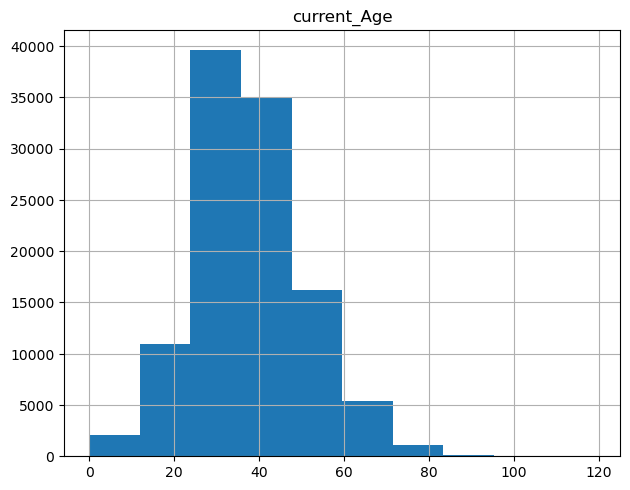

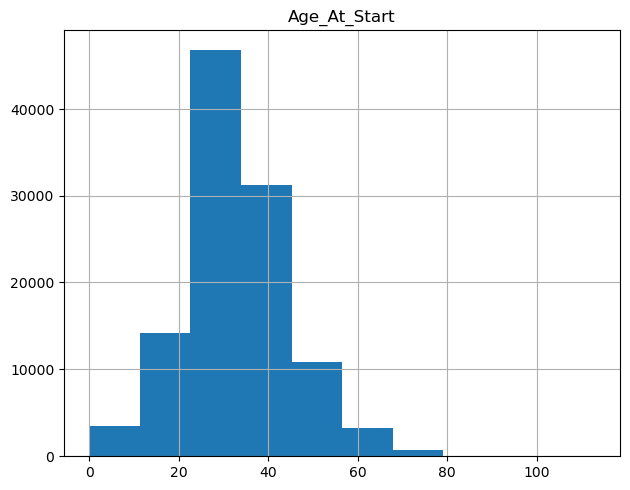

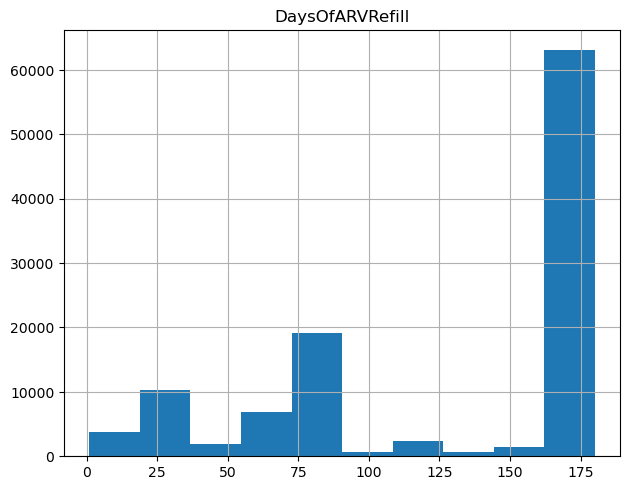

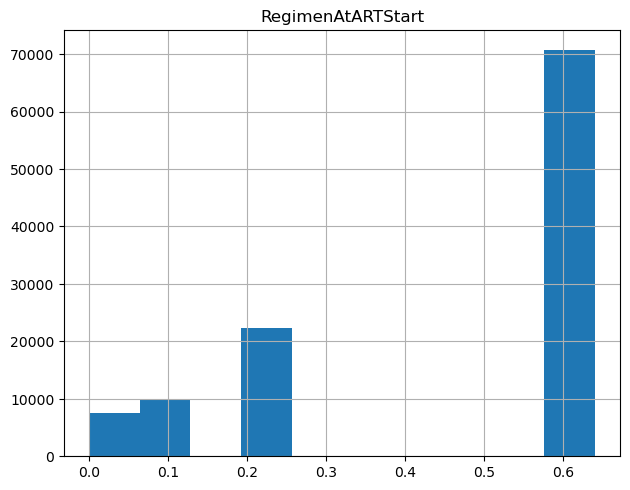

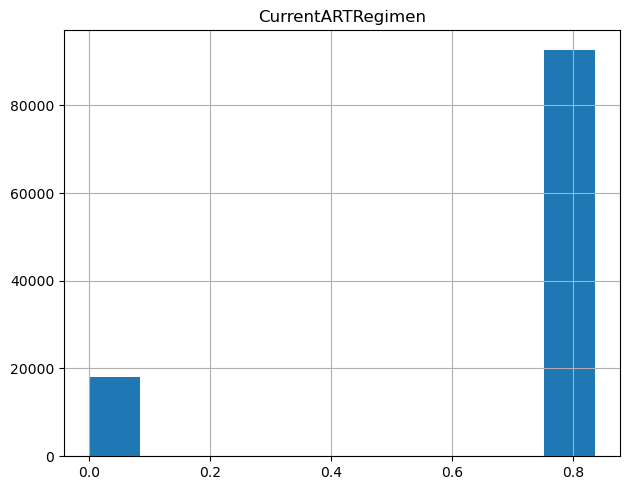

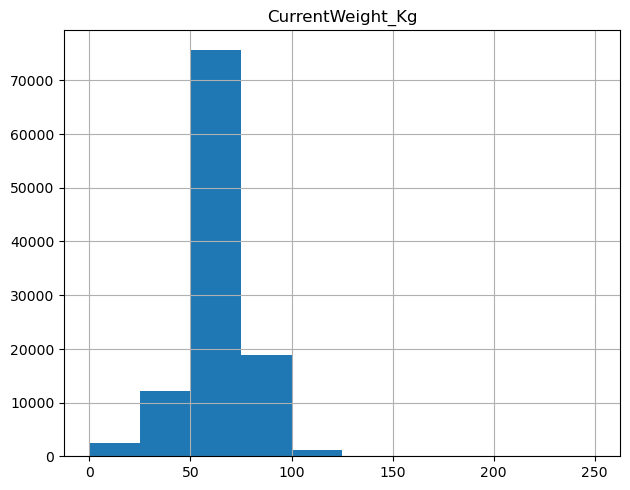

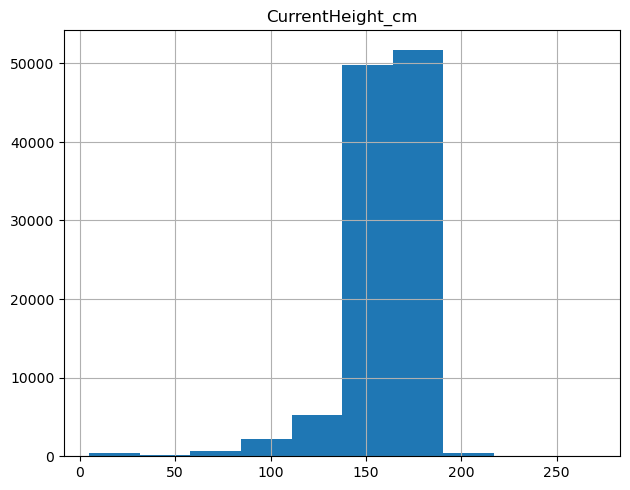

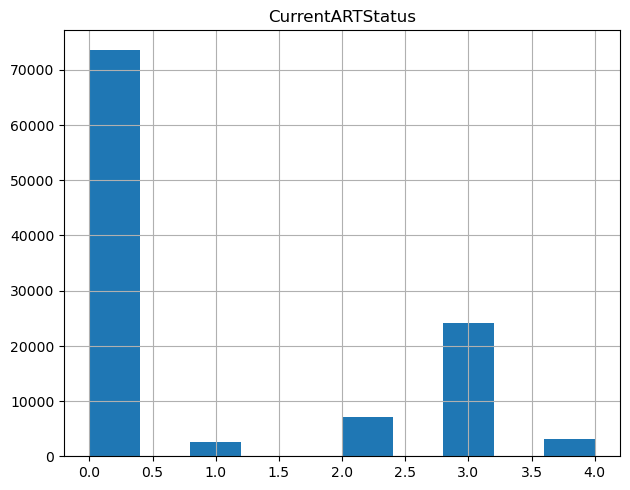

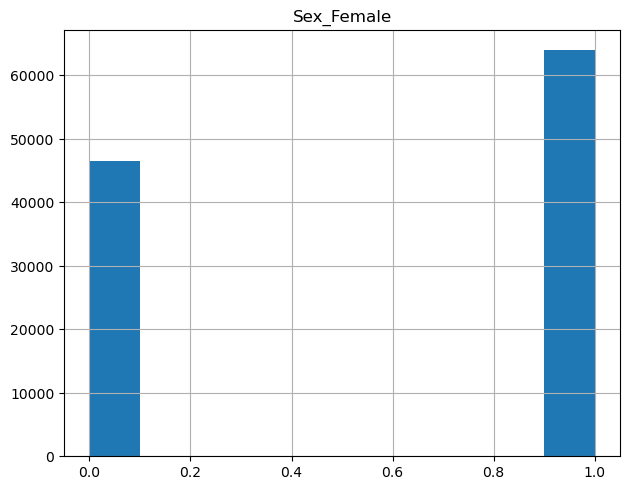

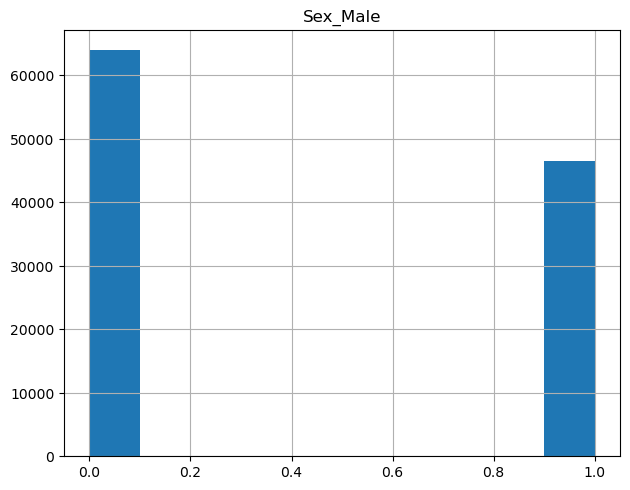

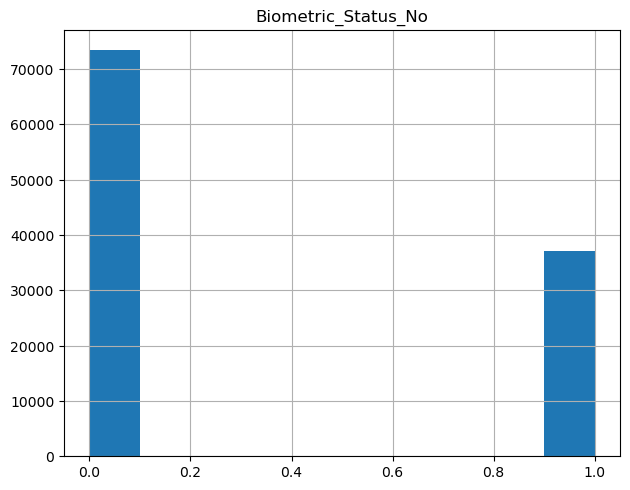

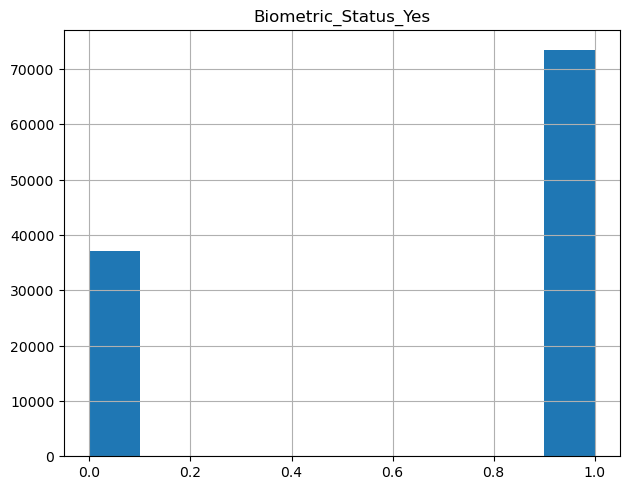

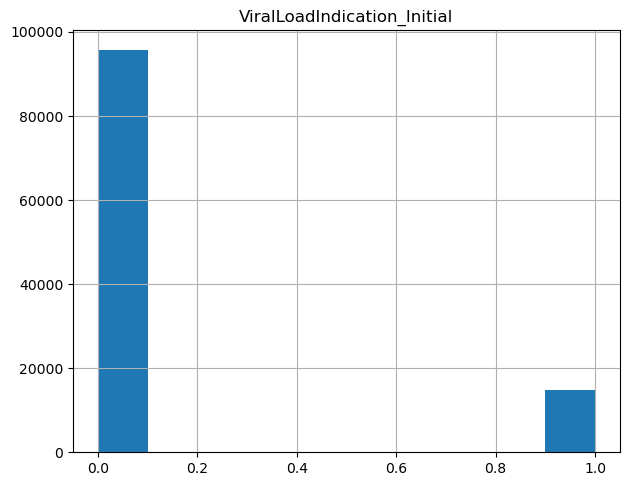

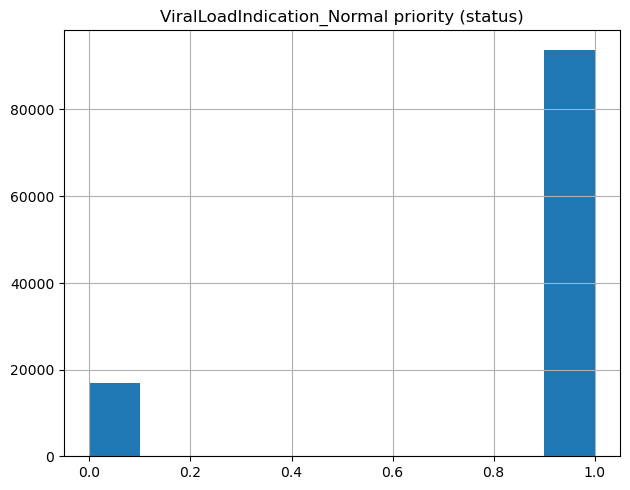

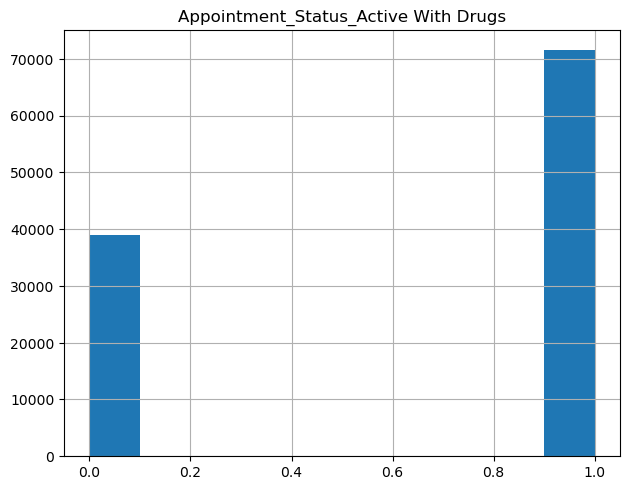

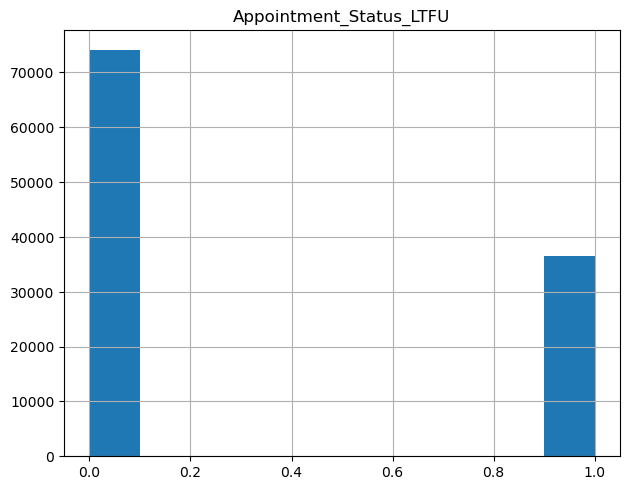

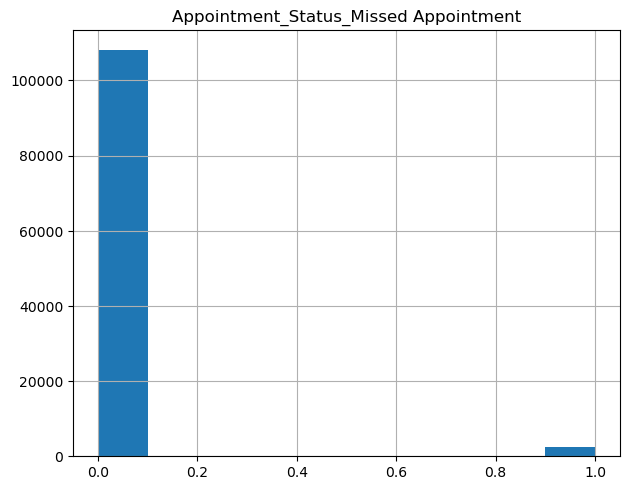

In [153]:
for col in ART_data.select_dtypes(['int', 'float']):
    #ART_data[col] = np.log1p(ART_data[col])
    ART_data[col].hist()
    plt.tight_layout()
    plt.title(col)
    plt.show()

In [154]:
# deal with column headers
ART_data.columns = ART_data.columns.str.replace(' ', '_', regex=False)
ART_data.rename( columns = {'ViralLoadIndication_Normal_priority_(status)': 'ViralLoadIndication_Normal_priority_status'}, inplace = True)
ART_data.columns

Index(['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'RegimenAtARTStart',
       'CurrentARTRegimen', 'CurrentWeight_Kg', 'CurrentHeight_cm',
       'CurrentARTStatus', 'Sex_Female', 'Sex_Male', 'Biometric_Status_No',
       'Biometric_Status_Yes', 'ViralLoadIndication_Initial',
       'ViralLoadIndication_Normal_priority_status',
       'Appointment_Status_Active_With_Drugs', 'Appointment_Status_LTFU',
       'Appointment_Status_Missed_Appointment'],
      dtype='object')

In [155]:
# Save data
ART_data.to_csv('ART_data.csv', index = False)

### Model_building

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [157]:
# Separate into independent and response variable
x = ART_data
y = ART_data.pop('CurrentARTStatus')

In [158]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Selection
models = {
    'Logistic_Regression': LogisticRegression(),
    'Decision_Tree': DecisionTreeClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'Gradient_Boosting': GradientBoostingClassifier()
}

# Model Training and Evaluation
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Logistic_Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     14784
           1       0.08      0.04      0.05       490
           2       0.35      0.03      0.06      1425
           3       0.70      0.92      0.79      4785
           4       0.04      0.00      0.01       613

    accuracy                           0.87     22097
   macro avg       0.43      0.40      0.38     22097
weighted avg       0.82      0.87      0.83     22097

[[14706    39     5    34     0]
 [  129    20     3   336     2]
 [  165    47    46  1141    26]
 [  166   121    60  4394    44]
 [  191    12    18   389     3]]
Decision_Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14784
           1       0.15      0.17      0.16       490
           2       0.33      0.34      0.34      1425
           3       0.77      0.75      0.76     

In terms of accuracy, Random forest is the best performing model with about 93% accuracy

### Print Feature Importance Using SHAP principle

In [123]:
import shap

In [159]:
# Fit model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

#explainer = shap.Explainer(random_forest, X_train)

RandomForestClassifier()

In [131]:
shap_values = explainer(X_test, check_additivity = False)

100%|===================| 110482/110485 [228:03<00:00]        

### Save Model


In [104]:
import pickle

In [160]:
with open('ART_RF_Model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)